In [1]:
import utils
import numpy as np
from tqdm import tqdm
import datetime

In [2]:
# 数据获取
df = utils.get_data(symbol='510300', save=False)
df = df.sort_values(['datetime'], ascending=True)
df = df.reset_index(drop=True)
df['pre_close'] = df['close'].shift(1)

In [3]:
# df.drop('value', axis=1,inplace=True)
df.dropna(inplace=True)

In [4]:
for day in [3, 5, 10, 13, 20, 30]:
    df['ma'+str(day)] = df.close.rolling(day).mean()
    
col = ['ma3', 'ma10', 'ma20', 'ma30']
tmp_df2 = df[col].shift(1)
tmp_df3 = df[col].shift(2)
for tmp_col in col:
    df[tmp_col + '_trend'] = 0
    df['rate1'] = (tmp_df2[tmp_col] - tmp_df3[tmp_col]) / (tmp_df3[tmp_col] + 0.00001)
    df['rate2'] = (df[tmp_col] - tmp_df2[tmp_col]) / (tmp_df2[tmp_col] + 0.00001)
    idx = (df['rate1'] > 0.00002) 
    df.loc[idx, tmp_col + '_trend'] = 1 # 趋势向上

    idx = (df['rate1'] < -0.00002) 
    df.loc[idx, tmp_col + '_trend'] = 2 # 趋势向下    

In [5]:
# 根据大盘指数来得到仓位设置
t = datetime.datetime.now()
today = int(str(t.year)+str(t.month).zfill(2)+str(t.day).zfill(2))
score_list_index, date_list = utils.comput_space(enddate=today)

In [6]:
df['year'] = df['year'].astype(int)
df['month'] = df['month'].astype(int)
df['day'] = df['day'].astype(int)

In [7]:
df.head()

,open,close,high,low,vol,amount,year,month,day,hour,...,ma10,ma13,ma20,ma30,ma3_trend,rate1,rate2,ma10_trend,ma20_trend,ma30_trend
1,3.864,3.848,3.864,3.834,8613700.0,33151096.0,2018,3,26,9,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,0
2,3.849,3.861,3.864,3.849,3010800.0,11603104.0,2018,3,26,9,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,0
3,3.861,3.866,3.866,3.860,4215800.0,16289184.0,2018,3,26,9,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,0
4,3.866,3.881,3.886,3.865,4829600.0,18718456.0,2018,3,26,9,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,0
5,3.881,3.882,3.885,3.878,3524200.0,13680840.0,2018,3,26,10,...,NaN,NaN,NaN,NaN,1,NaN,NaN,0,0,0


In [8]:
def print_info(hold_money, hold_market_value, index_df, i, kind, add_num):
    trade_date = index_df['datetime'][i]
    info = str(trade_date)
    if index_df['close'][i] > index_df['pre_close'][i]:
        info += ', 上涨，股价：' + str(index_df['close'][i])
    else:
        info += ', 下跌，股价：' + str(index_df['close'][i])
        
    if kind == 1:
        info += ', 加仓' + str(add_num) 
    
    elif kind == 2:
        info += ', 减仓' + str(add_num) 
    
    info += ',持有现金：'+str(round(hold_money,2))+',持有市值：'+\
    str(round(hold_market_value,2))+',总市值：'+str(round(hold_money+hold_market_value,2))
    print(info)

In [9]:
df = df.iloc[10730:].reset_index(drop=True)

# 有做T策略

In [10]:


# 一些参数初始化
money_init = 100000
hold_money = money_init #当前持有现金
hold_market_value = 0 # 当前股票市值
hold_market_value_list = [] # 每日持有的股票市值
hold_money_list = [] # 每日持有现金
all_value_list = [] # 总市值
hold_num = 0 # 持仓（手）
space = 0 # 目前仓位
today_sell_num = 0 # 当日可卖出手数
daylist = []

In [11]:
# 开始回测
num = 0
now_day = str(df['year'][0])+str(df['month'][0]).zfill(2)+str(df['day'][0]).zfill(2)
flag = 0 #0 不操作， 1 买入， 2 卖出
sell_today = True
buy_today = True
kind = 0
add_num = 0

i=0
tmp_day = str(df['year'][i])+str(df['month'][i]).zfill(2)+str(df['day'][i]).zfill(2)
idx = date_list.index(tmp_day)
prop_space = score_list_index[idx]

for i in range(len(df)):
    tmp_day = str(df['year'][i])+str(df['month'][i]).zfill(2)+str(df['day'][i]).zfill(2)
    
    if tmp_day not in daylist:
        daylist.append(tmp_day)
    
    if i>0 and buy_today and (df['ma5'][i] > df['ma30'][i]) and (df['ma5'][i-1] < df['ma30'][i-1]):
        # 金叉买入
        flag = 1
        buy_today = False
        add_mount = min(prop_space, 1 - prop_space)
        
    elif i>0 and sell_today and (df['ma5'][i] < df['ma30'][i]) and (df['ma5'][i-1] > df['ma30'][i-1]):
        # 死叉卖出
        flag = 2
        sell_today = False
        add_mount = min(prop_space, 1 - prop_space)
    
    
    # 如果开盘    
    if flag == 1 and add_mount>0:
        # 加仓，收盘价买入
#         add_mount = score_list_stock[i] - space
        buy_money = hold_money/(1-space)* (add_mount)
        add_num = buy_money // 100 // df['close'][i]
#         hold_market_value += add_num * 100 * df['close'][i]
        hold_money -= add_num * 100 * df['close'][i] * 1.0001
        hold_num += add_num
        kind = 1
        space += add_mount
        flag = 0
            
    elif flag == 2 and add_mount>0:
        # 减仓
        if today_sell_space != 0:
            
#             add_mount = space - score_list_stock[i]
            
             # 计算可以卖出的手数
            sell_mount = round(hold_num / space * (add_mount))
            if sell_mount > today_sell_num:
                sell_mount = today_sell_num
            today_sell_num -= sell_mount
            
            if add_mount > today_sell_space:
                # 大于当日可操作仓位
                add_mount = today_sell_space
            today_sell_space -= add_mount # 调整当日可操作仓位
              
            add_num = sell_mount
            hold_money += add_num * 100 * df['close'][i] * 0.9999
            hold_num -= add_num
            kind = 2
            space -= add_mount
            flag = 0
    
    if df['hour'][i] == 15:
        idx = date_list.index(tmp_day)
        prop_space = score_list_index[idx]
        if prop_space > space:
            add_mount = prop_space - space
            buy_money = hold_money/(1-space)* (add_mount)
            add_num = buy_money // 100 // df['close'][i]
            hold_money -= add_num * 100 * df['close'][i] * 1.0001
            hold_num += add_num
            kind = 1
            space += add_mount
            
        elif prop_space < space:
            add_mount = space - prop_space
             # 计算可以卖出的手数
            sell_mount = round(hold_num / space * (add_mount))
            if sell_mount > today_sell_num:
                sell_mount = today_sell_num
            today_sell_num -= sell_mount           
            if add_mount > today_sell_space:
                # 大于当日可操作仓位
                add_mount = today_sell_space
            today_sell_space -= add_mount # 调整当日可操作仓位
            add_num = sell_mount
            hold_money += add_num * 100 * df['close'][i] * 0.9999
            hold_num -= add_num
            kind = 2
            space -= add_mount
            
    hold_market_value = hold_num * 100 * df['close'][i]
    if add_num != 0:
        print_info(hold_money, hold_market_value, df, i, kind, add_num)
        add_num = 0
    # 判断是新的一天
    if df['hour'][i] == 15:
        num+=1
        today_sell_space = space # 重新更新可操作的仓位
        today_sell_num = hold_num
        hold_market_value_list.append(hold_market_value)
        hold_money_list.append(hold_money)
        all_value_list.append(hold_market_value+hold_money)
        sell_today = True
        buy_today = True
        flag = 0
        
hold_market_value_list.append(hold_market_value)
hold_money_list.append(hold_money)
all_value_list.append(hold_market_value+hold_money)

2019-02-26 15:00, 上涨，股价：3.69, 加仓271.0,持有现金：-9.0,持有市值：99999.0,总市值：99990.0
2019-03-08 15:00, 上涨，股价：3.661, 减仓108.0,持有现金：39525.85,持有市值：59674.3,总市值：99200.15
2019-03-11 10:50, 上涨，股价：3.678, 加仓107.0,持有现金：167.31,持有市值：99306.0,总市值：99473.31
2019-03-11 14:15, 上涨，股价：3.681, 减仓108.0,持有现金：39918.14,持有市值：59632.2,总市值：99550.34
2019-03-11 15:00, 下跌，股价：3.71, 加仓80.0,持有现金：10235.17,持有市值：89782.0,总市值：100017.17
2019-03-12 13:55, 下跌，股价：3.744, 减仓27.0,持有现金：20342.96,持有市值：80496.0,总市值：100838.96
2019-03-12 15:00, 上涨，股价：3.735, 加仓54.0,持有现金：171.94,持有市值：100471.5,总市值：100643.44
2019-03-13 15:00, 上涨，股价：3.713, 减仓134.0,持有现金：49921.16,持有市值：50125.5,总市值：100046.66
2019-03-14 09:55, 下跌，股价：3.725, 加仓133.0,持有现金：373.71,持有市值：99830.0,总市值：100203.71
2019-03-14 10:25, 下跌，股价：3.721, 减仓134.0,持有现金：50230.12,持有市值：49861.4,总市值：100091.52
2019-03-14 15:00, 上涨，股价：3.686, 加仓81.0,持有现金：20370.54,持有市值：79249.0,总市值：99619.54
2019-03-15 09:40, 上涨，股价：3.72, 加仓54.0,持有现金：280.53,持有市值：100068.0,总市值：100348.53
2019-03-15 13:25, 上涨，股价：3.727, 减仓54.0,持有现金：20404.32,持有市值：80130.5

2019-06-26 15:00, 下跌，股价：3.818, 减仓84.0,持有现金：32259.86,持有市值：74832.8,总市值：107092.66
2019-06-27 13:40, 上涨，股价：3.859, 减仓84.0,持有现金：64672.22,持有市值：43220.8,总市值：107893.02
2019-06-27 15:00, 上涨，股价：3.86, 加仓139.0,持有现金：11012.85,持有市值：96886.0,总市值：107898.85
2019-06-28 10:20, 上涨，股价：3.85, 加仓28.0,持有现金：231.77,持有市值：107415.0,总市值：107646.77
2019-06-28 10:35, 下跌，股价：3.847, 减仓28.0,持有现金：11002.29,持有市值：96559.7,总市值：107561.99
2019-06-28 15:00, 上涨，股价：3.859, 减仓28.0,持有现金：21806.41,持有市值：86055.7,总市值：107862.11
2019-07-01 13:40, 下跌，股价：3.943, 减仓56.0,持有现金：43885.01,持有市值：65848.1,总市值：109733.11
2019-07-01 14:05, 上涨，股价：3.958, 加仓55.0,持有现金：22113.83,持有市值：87867.6,总市值：109981.43
2019-07-01 15:00, 下跌，股价：3.954, 加仓55.0,持有现金：364.65,持有市值：109525.8,总市值：109890.45
2019-07-04 15:00, 上涨，股价：3.901, 减仓55.0,持有现金：21818.01,持有市值：86602.2,总市值：108420.21
2019-07-05 10:25, 上涨，股价：3.905, 加仓55.0,持有现金：338.36,持有市值：108168.5,总市值：108506.86
2019-07-05 15:00, 上涨，股价：3.921, 减仓28.0,持有现金：11316.06,持有市值：97632.9,总市值：108948.96
2019-07-08 09:35, 下跌，股价：3.876, 减仓28.0,持有现金：22167.78,持有市值

2019-10-08 10:10, 下跌，股价：3.905, 加仓56.0,持有现金：66416.24,持有市值：43345.5,总市值：109761.74
2019-10-08 13:45, 下跌，股价：3.906, 减仓55.0,持有现金：87897.09,持有市值：21873.6,总市值：109770.69
2019-10-09 10:40, 下跌，股价：3.897, 加仓27.0,持有现金：77374.14,持有市值：32345.1,总市值：109719.24
2019-10-09 11:05, 上涨，股价：3.892, 减仓28.0,持有现金：88270.65,持有市值：21406.0,总市值：109676.65
2019-10-09 15:00, 上涨，股价：3.905, 加仓28.0,持有现金：77335.56,持有市值：32411.5,总市值：109747.06
2019-10-10 15:00, 下跌，股价：3.933, 加仓55.0,持有现金：55701.89,持有市值：54275.4,总市值：109977.29
2019-10-11 10:55, 上涨，股价：3.934, 减仓138.0,持有现金：109985.66,持有市值：0.0,总市值：109985.66
2019-10-11 11:15, 下跌，股价：3.938, 加仓139.0,持有现金：55241.99,持有市值：54738.2,总市值：109980.19
2019-10-11 15:00, 上涨，股价：3.981, 加仓55.0,持有现金：33344.3,持有市值：77231.4,总市值：110575.7
2019-10-14 13:20, 下跌，股价：4.02, 减仓83.0,持有现金：66706.96,持有市值：44622.0,总市值：111328.96
2019-10-14 15:00, 下跌，股价：4.01, 加仓166.0,持有现金：134.31,持有市值：111077.0,总市值：111211.31
2019-10-15 15:00, 下跌，股价：3.997, 减仓28.0,持有现金：11324.79,持有市值：99525.3,总市值：110850.09
2019-10-16 10:25, 下跌，股价：3.999, 减仓28.0,持有现金：22520.87,持有市值：

2019-12-24 15:00, 下跌，股价：3.985, 减仓81.0,持有现金：32286.24,持有市值：75715.0,总市值：108001.24
2019-12-25 09:50, 上涨，股价：3.982, 减仓81.0,持有现金：64537.22,持有市值：43403.8,总市值：107941.02
2019-12-25 10:10, 上涨，股价：3.992, 加仓80.0,持有现金：32598.02,持有市值：75448.8,总市值：108046.82
2019-12-26 09:35, 上涨，股价：3.996, 加仓81.0,持有现金：227.19,持有市值：107892.0,总市值：108119.19
2019-12-26 13:15, 下跌，股价：4.002, 减仓81.0,持有现金：32640.14,持有市值：75637.8,总市值：108277.94
2019-12-26 15:00, 下跌，股价：4.021, 加仓26.0,持有现金：22184.5,持有市值：86451.5,总市值：108636.0
2019-12-27 13:35, 下跌，股价：4.033, 减仓54.0,持有现金：43960.52,持有市值：64931.3,总市值：108891.82
2019-12-27 15:00, 下跌，股价：4.017, 加仓109.0,持有现金：170.84,持有市值：108459.0,总市值：108629.84
2020-01-15 15:00, 下跌，股价：4.152, 减仓81.0,持有现金：33798.68,持有市值：78472.8,总市值：112271.48
2020-01-16 10:15, 下跌，股价：4.154, 加仓81.0,持有现金：147.91,持有市值：112158.0,总市值：112305.91
2020-01-16 10:35, 下跌，股价：4.15, 减仓81.0,持有现金：33759.55,持有市值：78435.0,总市值：112194.55
2020-01-16 15:00, 上涨，股价：4.146, 减仓54.0,持有现金：56145.71,持有市值：55971.0,总市值：112116.71
2020-01-17 11:25, 下跌，股价：4.144, 减仓135.0,持有现金：112084.12,持有市

In [12]:
rate1 = round(df['close'][len(df)-1] / df[df['hour']==15]['close'].iloc[0] - 1,2)
rate2 = round(all_value_list[-1] / money_init - 1, 2)

print('指数涨幅:'+str(rate1)+'， 账户涨幅：'+str(rate2)) # +', 最大回撤:'+str(max_return)

指数涨幅:0.02， 账户涨幅：0.08


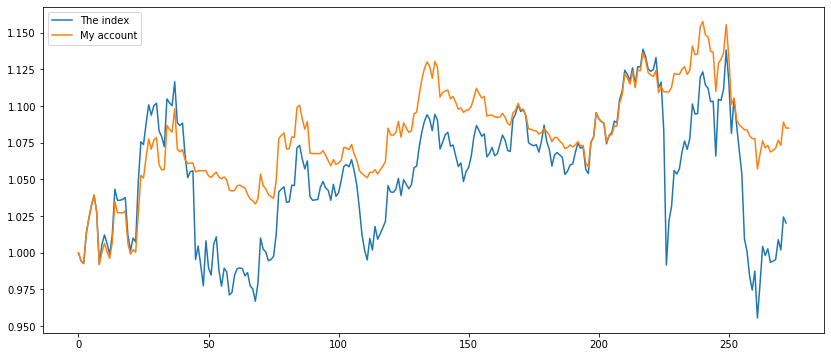

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
index = list(df[df['hour']==15]['close'] / df[df['hour']==15]['close'].iloc[0])
my_account = np.array(all_value_list) / money_init
plt.plot(index, label='The index')
plt.plot(my_account, label='My account')
plt.legend()
plt.show()

# 无做T策略

In [14]:


# 一些参数初始化
money_init = 100000
hold_money = money_init #当前持有现金
hold_market_value = 0 # 当前股票市值
hold_market_value_list = [] # 每日持有的股票市值
hold_money_list = [] # 每日持有现金
all_value_list = [] # 总市值
hold_num = 0 # 持仓（手）
space = 0 # 目前仓位
today_sell_num = 0 # 当日可卖出手数
daylist = []


# 开始回测
num = 0
now_day = str(df['year'][0])+str(df['month'][0]).zfill(2)+str(df['day'][0]).zfill(2)
flag = 0 #0 不操作， 1 买入， 2 卖出
sell_today = True
buy_today = True
kind = 0
add_num = 0

i=0
tmp_day = str(df['year'][i])+str(df['month'][i]).zfill(2)+str(df['day'][i]).zfill(2)
idx = date_list.index(tmp_day)
prop_space = score_list_index[idx]

for i in range(len(df)):
    tmp_day = str(df['year'][i])+str(df['month'][i]).zfill(2)+str(df['day'][i]).zfill(2)
    
    if tmp_day not in daylist:
        daylist.append(tmp_day)
    
    if df['hour'][i] == 15:
        idx = date_list.index(tmp_day)
        prop_space = score_list_index[idx]
        if prop_space > space:
            add_mount = prop_space - space
            buy_money = hold_money/(1-space)* (add_mount)
            add_num = buy_money // 100 // df['close'][i]
            hold_money -= add_num * 100 * df['close'][i] * 1.0001
            hold_num += add_num
            kind = 1
            space += add_mount
            
        elif prop_space < space:
            add_mount = space - prop_space
             # 计算可以卖出的手数
            sell_mount = round(hold_num / space * (add_mount))
            if sell_mount > today_sell_num:
                sell_mount = today_sell_num
            today_sell_num -= sell_mount           
            if add_mount > today_sell_space:
                # 大于当日可操作仓位
                add_mount = today_sell_space
            today_sell_space -= add_mount # 调整当日可操作仓位
            add_num = sell_mount
            hold_money += add_num * 100 * df['close'][i] * 0.9999
            hold_num -= add_num
            kind = 2
            space -= add_mount
            
    hold_market_value = hold_num * 100 * df['close'][i]
    if add_num != 0:
        print_info(hold_money, hold_market_value, df, i, kind, add_num)
        add_num = 0
    # 判断是新的一天
    if df['hour'][i] == 15:
        num+=1
        today_sell_space = space # 重新更新可操作的仓位
        today_sell_num = hold_num
        hold_market_value_list.append(hold_market_value)
        hold_money_list.append(hold_money)
        all_value_list.append(hold_market_value+hold_money)
        sell_today = True
        buy_today = True
        flag = 0
        
hold_market_value_list.append(hold_market_value)
hold_money_list.append(hold_money)
all_value_list.append(hold_market_value+hold_money)

2019-02-26 15:00, 上涨，股价：3.69, 加仓271.0,持有现金：-9.0,持有市值：99999.0,总市值：99990.0
2019-03-08 15:00, 上涨，股价：3.661, 减仓108.0,持有现金：39525.85,持有市值：59674.3,总市值：99200.15
2019-03-11 15:00, 下跌，股价：3.71, 加仓79.0,持有现金：10213.92,持有市值：89782.0,总市值：99995.92
2019-03-12 15:00, 上涨，股价：3.735, 加仓27.0,持有现金：128.41,持有市值：100471.5,总市值：100599.91
2019-03-13 15:00, 上涨，股价：3.713, 减仓134.0,持有现金：49877.63,持有市值：50125.5,总市值：100003.13
2019-03-14 15:00, 上涨，股价：3.686, 加仓81.0,持有现金：20018.05,持有市值：79617.6,总市值：99635.65
2019-03-15 15:00, 上涨，股价：3.735, 加仓26.0,持有现金：10306.07,持有市值：90387.0,总市值：100693.07
2019-03-18 15:00, 上涨，股价：3.85, 加仓26.0,持有现金：295.07,持有市值：103180.0,总市值：103475.07
2019-03-20 15:00, 下跌，股价：3.822, 减仓27.0,持有现金：10613.44,持有市值：92110.2,总市值：102723.64
2019-03-21 15:00, 上涨，股价：3.824, 加仓27.0,持有现金：287.61,持有市值：102483.2,总市值：102770.81
2019-03-22 15:00, 上涨，股价：3.829, 减仓27.0,持有现金：10624.88,持有市值：92278.9,总市值：102903.78
2019-03-25 15:00, 上涨，股价：3.734, 减仓54.0,持有现金：30786.46,持有市值：69825.8,总市值：100612.26
2019-03-26 15:00, 上涨，股价：3.695, 减仓107.0,持有现金：70319.01,持有市值：29560.

2019-11-22 15:00, 上涨，股价：3.908, 减仓26.0,持有现金：83049.67,持有市值：19930.8,总市值：102980.47
2019-11-25 15:00, 上涨，股价：3.936, 加仓26.0,持有现金：72815.05,持有市值：30307.2,总市值：103122.25
2019-11-26 15:00, 下跌，股价：3.942, 加仓52.0,持有现金：52314.6,持有市值：50851.8,总市值：103166.4
2019-11-27 15:00, 上涨，股价：3.936, 减仓77.0,持有现金：82618.77,持有市值：20467.2,总市值：103085.97
2019-11-28 15:00, 上涨，股价：3.93, 加仓26.0,持有现金：72399.75,持有市值：30654.0,总市值：103053.75
2019-11-29 15:00, 下跌，股价：3.887, 减仓26.0,持有现金：82504.93,持有市值：20212.4,总市值：102717.33
2019-12-03 15:00, 上涨，股价：3.911, 加仓26.0,持有现金：72335.32,持有市值：30505.8,总市值：102841.12
2019-12-04 15:00, 上涨，股价：3.913, 减仓26.0,持有现金：82508.1,持有市值：20347.6,总市值：102855.7
2019-12-05 15:00, 下跌，股价：3.942, 加仓78.0,持有现金：51757.43,持有市值：51246.0,总市值：103003.43
2019-12-06 15:00, 上涨，股价：3.966, 加仓78.0,持有现金：20819.53,持有市值：82492.8,总市值：103312.33
2019-12-11 15:00, 上涨，股价：3.9, 加仓26.0,持有现金：10678.52,持有市值：91260.0,总市值：101938.52
2019-12-12 15:00, 下跌，股价：3.889, 减仓78.0,持有现金：41009.68,持有市值：60668.4,总市值：101678.08
2019-12-13 15:00, 下跌，股价：3.968, 加仓103.0,持有现金：135.2,持有市值：1027

In [15]:
rate1 = round(df['close'][len(df)-1] / df['close'][0] - 1,2)
rate2 = round(all_value_list[-1] / money_init - 1, 2)

print('指数涨幅:'+str(rate1)+'， 账户涨幅：'+str(rate2)) # +', 最大回撤:'+str(max_return)

指数涨幅:0.01， 账户涨幅：0.0


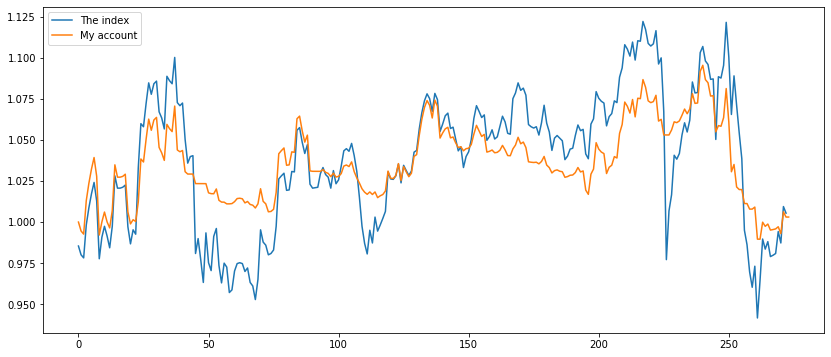

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
index = list(df[df['hour']==15]['close'] / df['close'][0])
my_account = np.array(all_value_list) / money_init
plt.plot(index, label='The index')
plt.plot(my_account, label='My account')
plt.legend()
plt.show()